In [ ]:
%%capture
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-hub
!pip install --upgrade tensorflow_text
!pip install --upgrade spacy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf

import tensorflow_text
import en_core_web_sm

from spacy.lang.fr.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras import Sequential

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

#EDA

In [ ]:
df = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv",encoding='ISO-8859-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# These unnamed columns seem to be where the data was accidentally split. That said, with only 50 such values, nothing major should be lost by dropping them.

x = df[df['Unnamed: 2'].isna() == False]
display(x.head())
x.count()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


v1            50
v2            50
Unnamed: 2    50
Unnamed: 3    12
Unnamed: 4     6
dtype: int64

In [ ]:
# Drop columns Unnamed: 2, Unnamed: 3, Unnamed: 4
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
# Rename columns v1 and v2 to 'classification' and 'text', respectively
df = df.rename(columns={'v1': 'classification', 'v2': 'text'})
df

,classification,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
display(df['classification'].value_counts(ascending=True))
df['classification'].isnull().sum()

spam     747
ham     4825
Name: classification, dtype: int64

0

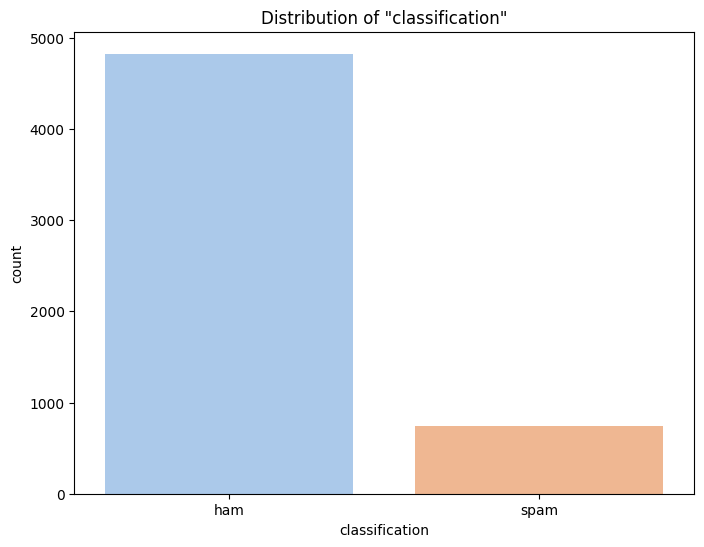

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x="classification", data=df, palette="pastel", hue="classification", legend=False)
plt.title('Distribution of "classification"')
plt.show()

In [ ]:
# The target variable is unbalanced, with 13.4% belonging to the 'spam' class.

print('Percentage of target variable represented by "spam":', df[df['classification'] == 'spam']['classification'].count() / df.shape[0] * 100)

Percentage of target variable represented by "spam": 13.406317300789663


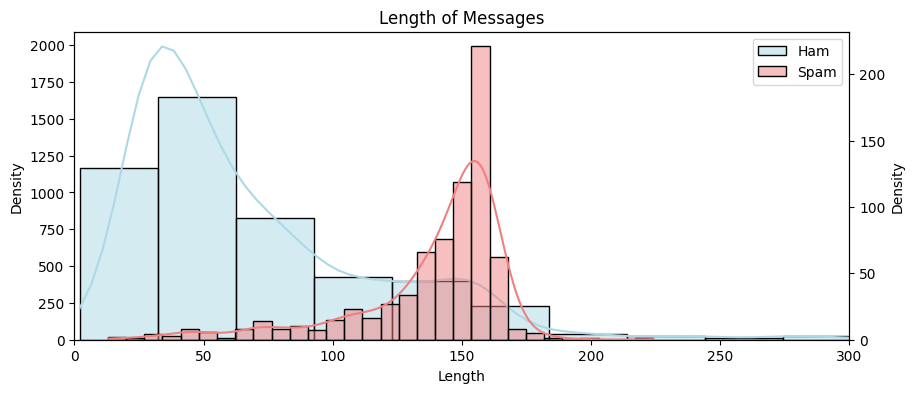

In [ ]:
# Length of Messages
df['length'] = df.text.apply(len)

# Subplots Length of Messages
_, ax1 = plt.subplots(figsize=(10, 4))

ax1.set(xlabel="Length", ylabel="Density", title="Length of Messages")
ax1.set_xlim(0, 300)

ax2 = ax1.twinx()
ax2.set_ylabel('Density')

sns.histplot(df.loc[df["classification"] == "ham", "length"], bins=30, color='lightblue', label="Ham", kde=True, ax=ax1)
sns.histplot(df.loc[df["classification"] == "spam", "length"], bins=30, color='lightcoral', label="Spam", kde=True, ax=ax2)

# Agregar etiquetas a la leyenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()


It can be observed that 'spam' messages tend to have longer text than non-spam messages

#Preprocessing

In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
# if saved file exists, skip these steps and load df = df.read_feather(file)

#remove any character that is not alphanumeric or a space
df["text_clean"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
#Replaces sequence of whitespace with a single space, converts to lowercase,removes leading and trailing whitespaces from the text
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
#lemmatize words in the text (token.lemma_) and excludes stop words from a predefined list (STOP_WORDS).
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
#tokenize with spacy
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.text for token in nlp(x)]))

df

,classification,text,length,text_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in 2 wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah do not think he go to usf he live around h...
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,this be the 2nd time we have try 2 contact u u...
5568,ham,Will Ì_ b going to esplanade fr home?,37,will ì b go to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,pity be in mood for that soany other sugges...
5570,ham,The guy did some bitching but I acted like i'd...,125,the guy do some bitching but act like d be int...


In [ ]:
df["text_clean"].notnull().sum()

5572

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df.text_clean)
df["text_encoded"] = tokenizer.texts_to_sequences(df.text_clean)

In [ ]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(df.text_encoded, padding="post")

In [ ]:
df['classification_code'] = df['classification'].apply(lambda x: 1 if x == 'spam' else 0)
df

,classification,text,length,text_clean,text_encoded,classification_code
0,ham,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...,"[20, 406, 1, 339, 579, 600, 65, 10, 1, 90, 111...",0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[47, 296, 601, 407, 7, 1]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in 2 wkly comp to win fa cup final ...,"[50, 421, 10, 23, 669, 805, 3, 87, 1, 999, 553...",1
3,ham,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say,"[7, 222, 61, 25, 249, 1, 7, 156, 139, 57, 61]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah do not think he go to usf he live around h...,"[851, 8, 6, 69, 36, 20, 3, 806, 36, 226, 201, ...",0
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,this be the 2nd time we have try 2 contact u u...,"[35, 2, 5, 377, 58, 28, 11, 112, 23, 166, 7, 7...",1
5568,ham,Will Ì_ b going to esplanade fr home?,37,will ì b go to esplanade fr home,"[26, 101, 191, 20, 3, 1, 716, 79]",0
5569,ham,"Pity, * was in mood for that. So...any other s...",57,pity be in mood for that soany other sugges...,"[1, 2, 10, 1, 13, 19, 1, 196, 1]",0
5570,ham,The guy did some bitching but I acted like i'd...,125,the guy do some bitching but act like d be int...,"[5, 200, 8, 103, 1, 27, 1, 53, 83, 2, 1, 10, 1...",0


In [ ]:
df.to_feather('processed_data.ftr')

## Model

In [ ]:
# Checking the sequence lenght long
max_sequence_length = max(len(seq) for seq in df['text_clean'].apply(tokenizer.texts_to_sequences))

# Split the original data into training and testing sets
x_train_bert, x_test_bert, y_train, y_test = train_test_split(df['text_clean'].values, df['classification_code'].values, test_size=0.3, random_state=42)

#tokenize and pad train data
x_train_encoded = tokenizer.texts_to_sequences(x_train_bert)
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_encoded, padding="post", maxlen=max_sequence_length)

# tokenize and pad test data
x_test_encoded = tokenizer.texts_to_sequences(x_test_bert)
x_test_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_encoded, padding="post", maxlen=max_sequence_length)


In [ ]:
max_sequence_length

857

In [ ]:
train = tf.data.Dataset.from_tensor_slices((x_train_padded, y_train))
val = tf.data.Dataset.from_tensor_slices((x_test_padded, y_test))

In [ ]:
train_batch = train.shuffle(len(train)).batch(64) #This is done to introduce randomness during training
val_batch = val.shuffle(len(val)).batch(64)

In [ ]:
# Check the actual length of texts in your training data
max_text_length = max(len(seq) for seq in df["text_encoded"])
print("maximum length of the encoded text sequences:", max_text_length)

maximum length of the encoded text sequences: 164


In [ ]:
vocab_size = tokenizer.num_words
embedding_dim = 50 #It refers to the number of dimensions in the vector space in which words or tokens are represented

In [ ]:
model_spam = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_shape=[max_sequence_length,], name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(name="global_average_pooling1d_5"),
    tf.keras.layers.Dense(64, activation='relu', name="dense_6"),
    tf.keras.layers.Dropout(0.2, name="dropout_2"),
    tf.keras.layers.Dense(32, activation='relu', name="dense_7"),
    tf.keras.layers.Dropout(0.2, name="dropout_3"),
    tf.keras.layers.Dense(1, activation='sigmoid', name="dense_8")
])

- Embedding Layer:converting tokenized sequences into meaningful word embeddings.
- Global Average Pooling Layer: to condense variable-length sequences into a fixed-size representation, promoting generalization.
- Dense Layers (dense_6, dense_7):for learning complex patterns and capturing hierarchical features within the data.
- Chose ReLU activation for introducing non-linearity.
- Dropout Layers (dropout_2, dropout_3):to prevent overfitting during training by randomly dropping a portion of neurons.
- Chose a dropout rate of 20% for both layers.
- Output Dense Layer (dense_8):A single neuron with sigmoid activation for binary classification (spam or not spam).

In [ ]:
model_spam.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 857, 50)           50050     
                                                                 
 global_average_pooling1d_5  (None, 50)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 64)                3264      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
# Model compile
model_spam.compile(optimizer='adam',
                   loss='binary_crossentropy',  # binary classification
                   metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history = model_spam.fit(x_train_padded, y_train,
                         epochs=50,
                         batch_size=32,
                         validation_data=(x_test_padded, y_test),
                         callbacks=[checkpoint, early_stopping])

Epoch 1/50
122/122 [==============================] - 14s 92ms/step - loss: 0.4667 - accuracy: 0.8605 - val_loss: 0.3847 - val_accuracy: 0.8690
Epoch 2/50
122/122 [==============================] - 3s 26ms/step - loss: 0.3976 - accuracy: 0.8646 - val_loss: 0.3818 - val_accuracy: 0.8690
Epoch 3/50
122/122 [==============================] - 3s 22ms/step - loss: 0.3944 - accuracy: 0.8646 - val_loss: 0.3809 - val_accuracy: 0.8690
Epoch 4/50
122/122 [==============================] - 1s 12ms/step - loss: 0.3866 - accuracy: 0.8646 - val_loss: 0.3681 - val_accuracy: 0.8690
Epoch 5/50
122/122 [==============================] - 1s 12ms/step - loss: 0.3744 - accuracy: 0.8646 - val_loss: 0.3411 - val_accuracy: 0.8690
Epoch 6/50
122/122 [==============================] - 1s 6ms/step - loss: 0.3053 - accuracy: 0.8651 - val_loss: 0.2324 - val_accuracy: 0.8690
Epoch 7/50
122/122 [==============================] - 1s 9ms/step - loss: 0.1823 - accuracy: 0.9249 - val_loss: 0.1254 - val_accuracy: 0.9611


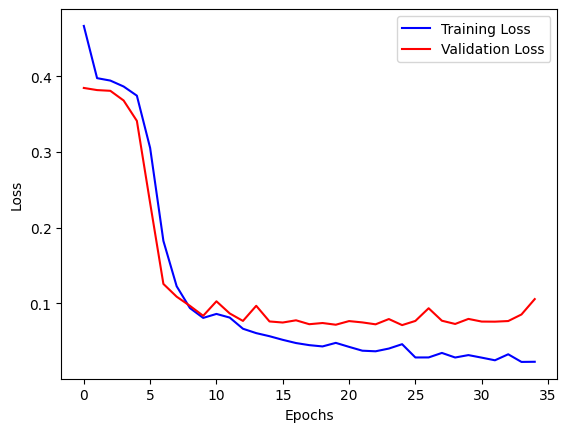

In [ ]:
# Visualize the loss during training
plt.plot(history.history["loss"], color="b", label="Training Loss")
plt.plot(history.history["val_loss"], color="r", label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

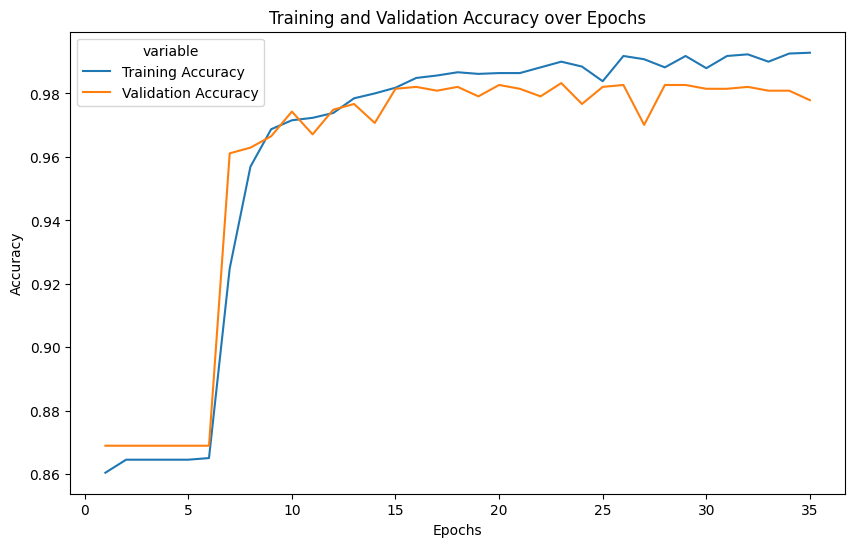

In [ ]:
# Create a DataFrame with accuracy and validation accuracy data
accuracy_data = pd.DataFrame({
    'Epochs': range(1, len(history.history['accuracy']) + 1),
    'Training Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy']
})

# Use Seaborn to visualize the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epochs', y='value', hue='variable', data=pd.melt(accuracy_data, ['Epochs']))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

53/53 [==============================] - 0s 2ms/step


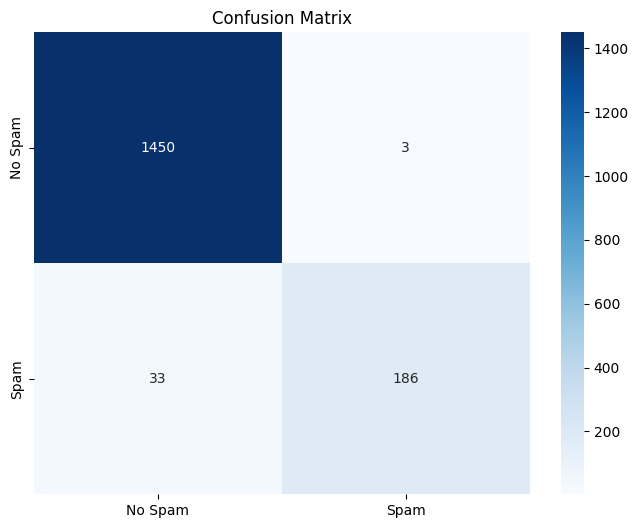

F1 Score: 0.9117647058823529


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate predictions
y_pred_spam = model_spam.predict(x_test_padded)
y_pred_class_spam = (y_pred_spam > 0.3).astype(int)

# Calculate and visualize the confusion matrix
cm_spam = confusion_matrix(y_test, y_pred_class_spam)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_spam, annot=True, fmt='d', cmap='Blues', xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])

plt.title('Confusion Matrix')
plt.show()

# Calculate and visualize the F1 Score
f1 = f1_score(y_test, y_pred_class_spam)
print(f"F1 Score: {f1}")

The F1 score shows a good result, but let's try to achieve better results with a pre-existing model

## BERT Model

In [ ]:
# BERT model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

# layers
x_pooled = tf.keras.layers.Dropout(0.2, name='dropout_pooled')(pooled_output)
x_pooled = tf.keras.layers.Dense(64, activation='relu', name='hidden_pooled')(x_pooled)
x_sequence = tf.keras.layers.Dropout(0.2, name='dropout_sequence')(sequence_output)
x_sequence_pooled = tf.keras.layers.GlobalAveragePooling1D()(x_sequence)
x_pooled_reduced = tf.keras.layers.Dense(64, activation='relu', name='reduce_dim_pooled')(x_pooled)
x_concatenated = tf.keras.layers.Concatenate()([x_pooled_reduced, x_sequence_pooled])
x_concatenated = tf.keras.layers.Dense(32, activation='relu', name='hidden_concatenated')(x_concatenated)
x_concatenated = tf.keras.layers.Dense(8, activation='relu', name='hidden_concatenated_2')(x_concatenated)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x_concatenated)

# Create model
model_ps = tf.keras.Model(inputs=[text_input], outputs=[output])

# Compile model
model_ps.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



- Dropout layer after pooled_output and sequence_output:
Dropout helps to regularize the model by randomly turning off some neurons during training, which prevents overfitting and improves the model's generalization.

- Dense layer after pooled_output:
This dense layer can help learn more complex and rich features from the text, which may enhance the model's representation capability and its ability to extract relevant features.

- GlobalAveragePooling1D layer after sequence_output:
This calculates the average of each dimension across sequences, reducing the output's dimensionality and potentially simplifying the representation while extracting more relevant features.

- Dimensionality reduction for pooled_output:
This can improve computational efficiency and prevent overfitting by limiting the model's complexity.

- Concatenation of pooled_output and sequence_output:
After separately processing pooled_output and sequence_output, their outputs are concatenated before passing them to additional layers. This allows the model to access both the high-level (global) representation and the detailed (sequential) representation of the data.

the last layer uses a sigmoid activation function ('sigmoid') and has a single unit (Dense(1)). This configuration is commonly used for binary classification problems.
The sigmoid function compresses values to a range between 0 and 1, which is suitable for binary classification problems where we want to predict the probability of an instance belonging to the positive class (in this case, the probability of an email being spam)
Alsp since we are performing binary classification, we only need one output to predict the probability of an instance.

In [ ]:
model_ps.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_4 (KerasLayer)  {'input_word_ids': (None,    0         ['input_3[0][0]']             
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [ ]:
# Checkpoints and early stopping
checkpoint = ModelCheckpoint('best_model_bert.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')

# Entrenar modelo
history_ps = model_ps.fit(x_train_bert, y_train, epochs=20, batch_size=32, validation_data=(x_test_bert, y_test), callbacks=[checkpoint, early_stopping])


Epoch 1/20
122/122 [==============================] - 81s 589ms/step - loss: 0.1316 - accuracy: 0.9554 - val_loss: 0.0505 - val_accuracy: 0.9856
Epoch 2/20
122/122 [==============================] - 69s 569ms/step - loss: 0.0491 - accuracy: 0.9854 - val_loss: 0.0402 - val_accuracy: 0.9904
Epoch 3/20
122/122 [==============================] - 62s 511ms/step - loss: 0.0403 - accuracy: 0.9882 - val_loss: 0.0454 - val_accuracy: 0.9886
Epoch 4/20
122/122 [==============================] - 62s 510ms/step - loss: 0.0352 - accuracy: 0.9882 - val_loss: 0.0439 - val_accuracy: 0.9868
Epoch 5/20
122/122 [==============================] - 66s 540ms/step - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.0352 - val_accuracy: 0.9916
Epoch 6/20
122/122 [==============================] - 63s 516ms/step - loss: 0.0246 - accuracy: 0.9933 - val_loss: 0.0327 - val_accuracy: 0.9922
Epoch 7/20
122/122 [==============================] - 62s 510ms/step - loss: 0.0240 - accuracy: 0.9918 - val_loss: 0.0337 - val_ac

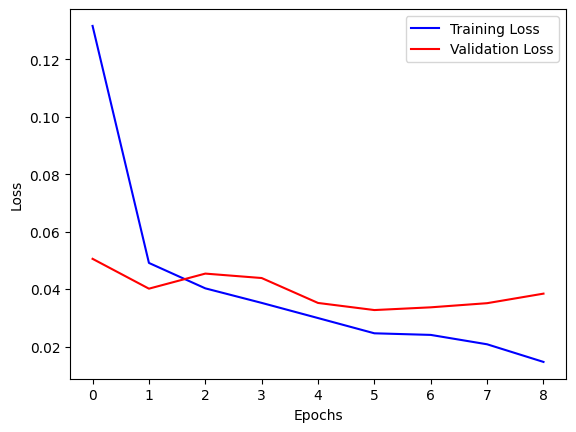

In [ ]:
# Visualize the loss during training
plt.plot(history_ps.history["loss"], color="b", label="Training Loss")
plt.plot(history_ps.history["val_loss"], color="r", label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

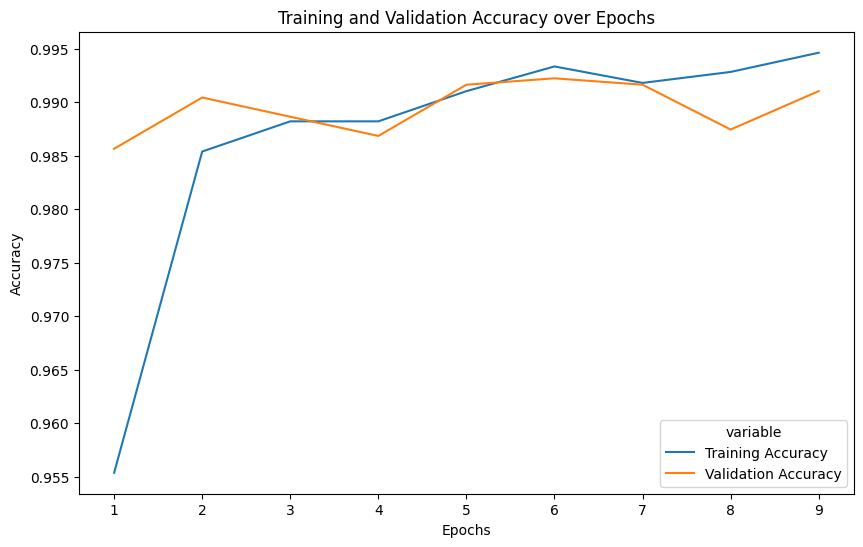

In [ ]:
# Create a DataFrame with accuracy and validation accuracy data
accuracy_data = pd.DataFrame({
    'Epochs': range(1, len(history_ps.history['accuracy']) + 1),
    'Training Accuracy': history_ps.history['accuracy'],
    'Validation Accuracy': history_ps.history['val_accuracy']
})

# Use Seaborn to visualize the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epochs', y='value', hue='variable', data=pd.melt(accuracy_data, ['Epochs']))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

53/53 [==============================] - 18s 337ms/step


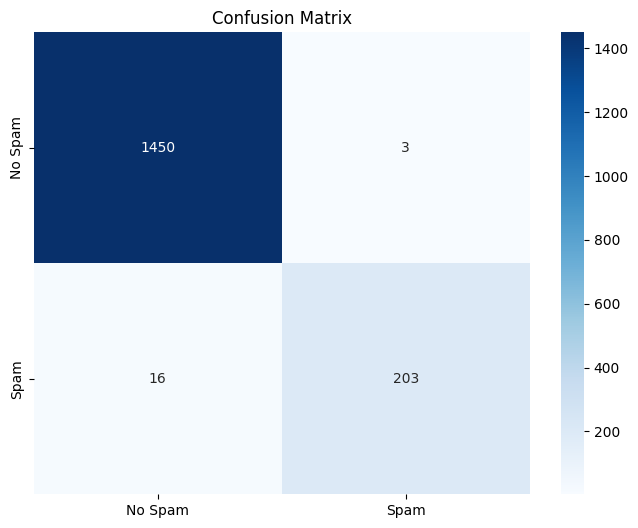

F1 Score: 0.9552941176470588


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Calculate predictions
y_pred = model_ps.predict(x_test_bert)
y_pred_class = (y_pred > 0.7).astype(int)

# Calculate and visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])

plt.title('Confusion Matrix')
plt.show()

# Calculate and visualize the F1 Score
f1 = f1_score(y_test, y_pred_class)
print(f"F1 Score: {f1}")

The F1 Score is indicating a strong balance between precision and recall. The confusion matrix shows that the model made 1450 correct predictions for "No Spam" and 203 correct predictions for "Spam.".The model demonstrates high performance with a few misclassifications.

As expected, the results using the BERT model are better. The F1 score has increased, and there are fewer mispredictions.
